In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mmctools.plotting import plot_timeheight, plot_profile, plot_timehistory_at_height
from mmctools.helper_functions import T_to_Tv, theta

In [2]:
sowfa_dz = 10.
sowfa_zmax = 2000.
sowfa_cc_heights = np.arange(sowfa_dz/2,sowfa_zmax,sowfa_dz)

In [3]:
# generated by process_TTU_tower.ipynb
towerdata = 'data/TTU_tilt_corrected_20131108-09_10min.csv'
# generated by process_TTU_radar.ipynb
radardata = 'data/radar_rass.z01.00_20131108.csv'

In [4]:
alltimes = pd.date_range('2013-11-08 00:00','2013-11-10 00:00',freq='10min',name='datetime')

## load data

### near-surface tower data

In [5]:
tower = pd.read_csv(towerdata,parse_dates=['datetime'])
tower = tower.set_index(['datetime','height'])
tower['Tv'] = T_to_Tv(tower['T'],RH=tower['RH'],p=tower['p'])

In [6]:
# fill in missing last time 
tower = tower.unstack().reindex(alltimes).ffill().stack()

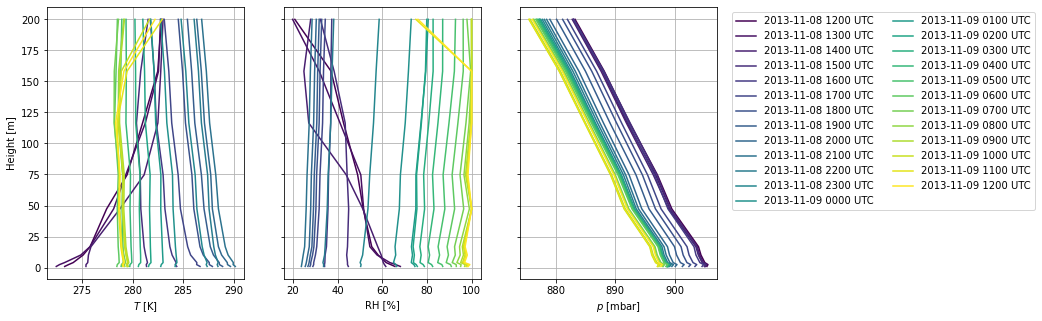

In [7]:
hourly = pd.date_range('2013-11-08 12:00', '2013-11-09 12:00', freq='1h')
fig,ax = plot_profile(tower, fields=['T','RH','p'], 
                      fieldlabels={'T':'$T$ [K]', 'RH':'RH [%]', 'p':'$p$ [mbar]'},
                      times=hourly, cmap='viridis')
ax[-1].legend(loc='upper left', bbox_to_anchor=(1.05,1), ncol=2)

In [8]:
z = tower.index.levels[1].values
z

array([  0.9,   2.4,   4. ,  10.1,  16.8,  47.3,  74.7, 116.5, 158.2,
       200. ])

<font color='red'>ASSUMPTION:</font> Scale height ($H$) is invariant, to get pressure as a function of surface pressure, $p \approx p_0 \exp(-z/H)$

In [9]:
p0 = tower['p'].xs(z[0], level='height')
log_pnorm = np.log(tower['p'] / p0).unstack()
log_pnorm.head()

height,0.9,2.4,4.0,10.1,16.8,47.3,74.7,116.5,158.2,200.0
datetime,,,,,,,,,,
2013-11-08 00:00:00,0.0,0.000193,-0.000366,-0.001031,-0.001366,-0.006223,-0.008725,-0.013608,-0.018288,-0.023899
2013-11-08 00:10:00,0.0,0.000293,-0.000341,-0.001019,-0.001365,-0.006198,-0.008683,-0.013568,-0.018301,-0.023914
2013-11-08 00:20:00,0.0,0.000281,-0.000352,-0.001032,-0.001408,-0.006246,-0.008746,-0.013651,-0.018361,-0.023954
2013-11-08 00:30:00,0.0,0.000236,-0.000354,-0.001019,-0.001465,-0.006292,-0.008817,-0.013700,-0.018442,-0.023992
2013-11-08 00:40:00,0.0,0.000271,-0.000342,-0.001016,-0.001426,-0.006262,-0.008811,-0.013661,-0.018368,-0.023971


Solve $-\frac{z}{H} = \ln(p/p_0)$

In [10]:
# i.e., solve Ax = b
AtA = z.dot(z)
def estimate_scale_height(log_pnorm_at_t):
    Atb = z.dot(log_pnorm_at_t)
    x = Atb / AtA
    return -1/x

In [11]:
scale_heights = log_pnorm.apply(estimate_scale_height, axis=1)
H = scale_heights.mean()
H

8369.374877104

Text(0.5, 1.0, '2013-11-09 00:00')

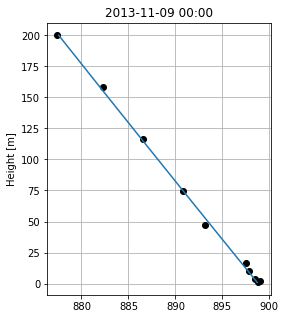

In [12]:
testtime = '2013-11-09 00:00'
fig,ax = plot_profile(tower, fields='p', times=testtime, marker='o', color='k', linestyle='none')
ax.plot(p0.loc[testtime]*np.exp(-z/H), z)
ax.set_title(testtime)

### data from radar Radio Acoustic Sounding System 
NOTE: `T` and `Tc` are uncorrected and corrected _virtual_ temperature [deg C], respectively

NOTE: data should already be QC'd

In [13]:
rass = pd.read_csv(radardata,parse_dates=['datetime'])
rass = rass.set_index(['datetime','height'])

In [14]:
#rass.loc[rass['T'].isna(),['SNR.0','SNR.1','SNR.2']].describe()

In [15]:
#rass.loc[~rass['T'].isna(),['SNR.0','SNR.1','SNR.2']].describe()

Text(0.5, 1.0, 'corrected')

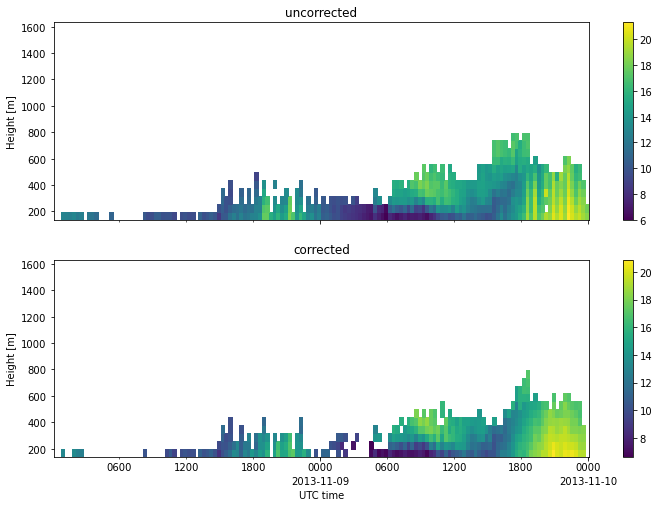

In [16]:
fig,ax,cb = plot_timeheight(rass,fields=['T','Tc'])
ax[0].set_title('uncorrected')
ax[1].set_title('corrected')

In [17]:
rass['Tc']

datetime             height
2013-11-08 00:17:08  165.0    NaN
                     225.0    NaN
                     285.0    NaN
                     345.0    NaN
                     405.0    NaN
                               ..
2013-11-09 23:57:11  1364.0   NaN
                     1424.0   NaN
                     1484.0   NaN
                     1543.0   NaN
                     1603.0   NaN
Name: Tc, Length: 3600, dtype: float64

Text(0.5, 1.0, 'resampled')

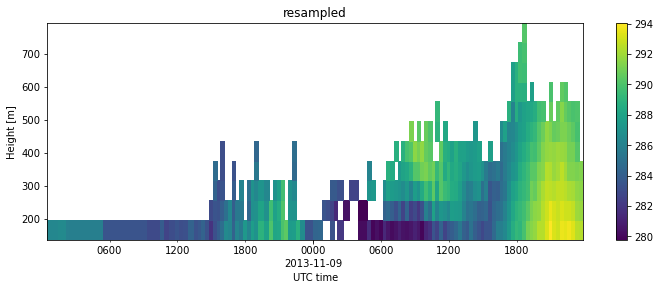

In [18]:
# sampling period ~ 20 min
rass_Tv = rass['Tc'].unstack().resample('20min').nearest().stack().rename('Tv')
rass_Tv += 273.15
fig,ax,cb = plot_timeheight(rass_Tv)
ax.set_title('resampled')

### read sounding data
from http://weather.uwyo.edu/upperair/sounding.html, manually copied/pasted into text files

In [19]:
zsonde = pd.Index(np.arange(0,sowfa_zmax+1,sowfa_dz/2), name='height')

def read_sounding(site,datetime):
    datetime = pd.to_datetime(datetime)
    # e.g., data/soundings/MAF_20131108_00Z.txt
    fpath = os.path.join('data','soundings',datetime.strftime(f'{site}_%Y%m%d_%HZ.txt'))
    if not os.path.isfile(fpath):
        return None, None
    print('Reading',fpath)
    with open(fpath,'r') as f:
        # header
        f.readline()
        channels = f.readline().split()
        units = f.readline().split()
        units = dict(zip(channels,units))
        f.readline()
        # find starting data level
        Nchannels = len(channels)
        datastart = f.tell()
        while len(f.readline().split()) < Nchannels:
            datastart = f.tell()
        f.seek(datastart)
        # read data
        df = pd.read_csv(f, delim_whitespace=True, header=None, names=channels)
    assert (units['THTV'] == 'K')
    df = df.rename(columns=dict(HGHT='height',PRES='p',THTV='thetav'))
    df['height'] -= df['height'][0] # convert to height AGL
    df = df.set_index('height')
    raw = df['thetav']
    # regularize heights
    reg = raw.drop_duplicates()
    zactual = reg.index
    allz = zactual.union(zsonde).drop_duplicates()
    reg = reg.reindex(allz)
    reg = reg.interpolate(method='index').reindex(zsonde)
    return raw, reg

Reading data/soundings/MAF_20131108_00Z.txt
Reading data/soundings/AMA_20131108_00Z.txt
Reading data/soundings/MAF_20131108_12Z.txt
Reading data/soundings/AMA_20131108_12Z.txt
Reading data/soundings/MAF_20131109_00Z.txt
Reading data/soundings/MAF_20131109_12Z.txt
Reading data/soundings/AMA_20131109_12Z.txt
Reading data/soundings/MAF_20131110_00Z.txt
Reading data/soundings/AMA_20131110_00Z.txt


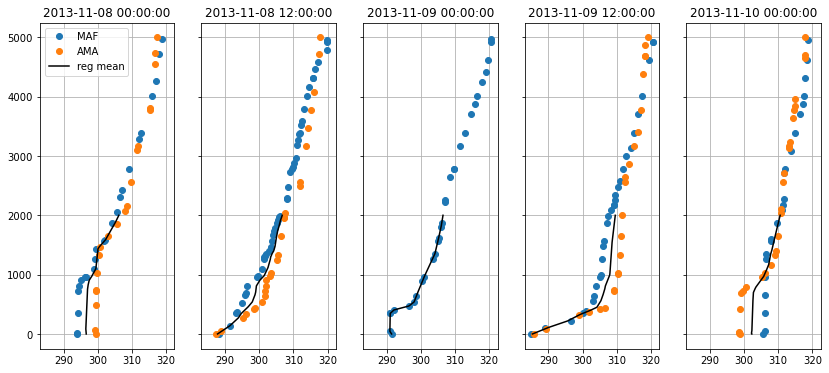

In [20]:
soundings = []
soundings_raw = []
selected_sites = ['MAF','AMA']
datetimes = pd.date_range('2013-11-08 00:00','2013-11-10 00:00',freq='12H')
fig,ax = plt.subplots(ncols=len(datetimes), sharex=True, sharey=True, figsize=(14,6))
for i,datetime in enumerate(datetimes):
    regmean = None
    Nmean = 0
    for site in selected_sites:
        raw,reg = read_sounding(site,datetime)
        if raw is not None:
            tmp = raw.loc[raw.index < 5000.]
            ax[i].plot(tmp, tmp.index, 'o', label=site)
            if regmean is None:
                regmean = reg
            else:
                regmean += reg
            Nmean += 1
            
            tmp = pd.DataFrame(tmp)
            tmp['datetime'] = datetime
            tmp = tmp.set_index('datetime',append=True).reorder_levels(['datetime','height']).sort_index()
            soundings_raw.append(tmp)
            
    # average across sites
    if Nmean > 0:
        regmean /= Nmean
        ax[i].plot(regmean, regmean.index, color='k', label='reg mean')
        ax[i].set_title(datetime)
    ax[i].grid()
    # add indexing information for combination later
    regmean = pd.DataFrame(regmean)
    regmean['datetime'] = datetime
    regmean = regmean.set_index('datetime',append=True).reorder_levels(['datetime','height']).sort_index()
    soundings.append(regmean)
ax[0].legend()

## combine and calculate additonal quantities

In [21]:
combined = pd.concat([tower[['p','Tv']], pd.DataFrame(rass_Tv)], axis=0).sort_index()

In [22]:
def approx_p_profile(profile):
    # for RASS, to convert from Tv to thetav
    p0 = profile.loc[0.9]
    tofill = profile.isna()
    z = profile.loc[tofill].index
    profile.loc[tofill] = p0 * np.exp(-z/H)
    return profile
combined = combined.unstack()
combined['p'] = combined['p'].apply(approx_p_profile, axis=1)
combined = combined.stack()

In [23]:
# now we can calculate virtual potential temperature
combined['thetav'] = theta(combined['Tv'], p=combined['p'])

In [24]:
combined = combined.unstack().interpolate(method='index',limit=1).stack() # fill RASS gaps, b/c data interval ~20 min

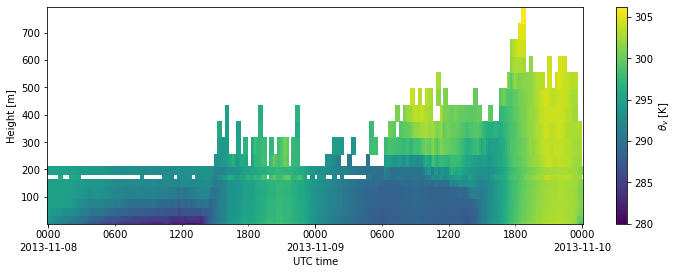

In [25]:
fig,ax,cb = plot_timeheight(combined,fields='thetav')
fig.savefig('figures/combined_radar_met_thetav.png',bbox_inches='tight')

In [26]:
#soundings = pd.concat(soundings)

<font color='red'>ASSUMPTION:</font> Tower top T/RH measurements should be discarded (doesn't look right from first figure)

In [27]:
zref = z[-2] # note T/RH doesn't look right at the highest measurement height (from first figure)

In [28]:
discard = combined.index.get_level_values('height') == z[-1]
combined = combined.loc[~discard,:]
combined = combined.sort_index()

<font color='red'>ASSUMPTION:</font> Shift sounding profile so that $\theta_v$ matches top of tower

In [132]:
soundings_shifted = []
thetav_offsets = []
for sounding in soundings:
    datetime = sounding.index.levels[0]
    assert len(datetime) == 1
    thetav_ref = combined.loc[(datetime[0],zref),'thetav']
    thetav_sonde = np.interp(zref, sounding.index.get_level_values('height'), sounding.values.flatten())
    delta_thetav = thetav_ref - thetav_sonde
    print(f'{str(datetime[0])} : {thetav_sonde:g} {thetav_ref:g}, shift by {delta_thetav:g} K')
    soundings_shifted.append(sounding + delta_thetav)
    thetav_offsets.append(delta_thetav)
soundings_shifted = pd.concat(soundings_shifted)

2013-11-08 00:00:00 : 296.58 295.022, shift by -1.55809 K
2013-11-08 12:00:00 : 291.751 292.415, shift by 0.663808 K
2013-11-09 00:00:00 : 290.937 293.664, shift by 2.72674 K
2013-11-09 12:00:00 : 292.505 289.576, shift by -2.92978 K
2013-11-10 00:00:00 : 302.317 301.345, shift by -0.972514 K


In [134]:
thetav_offsets = pd.DataFrame({'thetav':thetav_offsets}, index=soundings_shifted.index.levels[0])

Text(0.5, 1.0, 'z = 158.2 m')

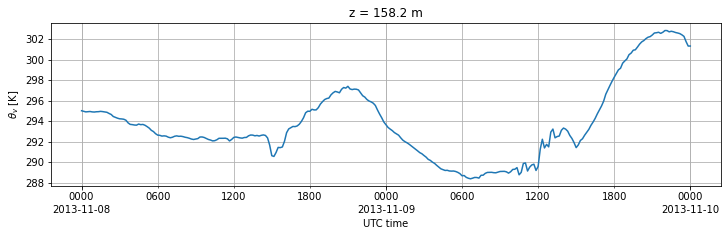

In [30]:
fig,ax = plot_timehistory_at_height(combined, fields='thetav', heights=zref)
ax.set_title(f'z = {zref:g} m')

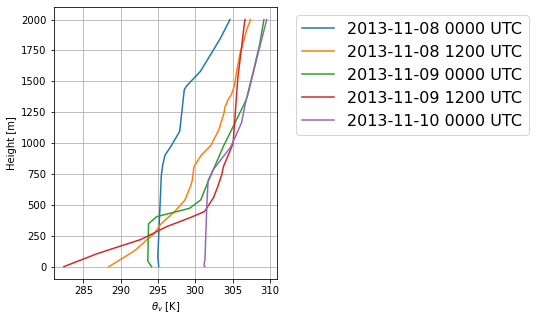

In [31]:
fig,ax = plot_profile(soundings_shifted,fields='thetav',times=soundings_shifted.index.levels[0])

In [32]:
# add sounding data
combined1 = pd.concat([combined.dropna(axis=0,how='any',thresh=2), soundings_shifted]) # drop RASS nans
dup = combined1.index.duplicated(keep='first') # keep local tower/RASS data over remote sounding
print('duplicates at',np.count_nonzero(dup), combined1.index[dup])
combined1 = combined1.loc[~dup]
combined1 = combined1.sort_index()

duplicates at 6 MultiIndex([('2013-11-08 12:00:00', 165.0),
            ('2013-11-09 12:00:00', 165.0),
            ('2013-11-09 12:00:00', 225.0),
            ('2013-11-09 12:00:00', 285.0),
            ('2013-11-09 12:00:00', 345.0),
            ('2013-11-09 12:00:00', 405.0)],
           names=['datetime', 'height'])


In [33]:
# data should now be at 10-min, 5-m resolution
combined1 = combined1.unstack(level='datetime').interpolate(method='index', limit_direction='backward').stack() # linearly interpolate in the vertical
combined1 = combined1.reorder_levels(['datetime','height']).sort_index()
fig.savefig('figures/combined_radar_met_sounding_thetav.png',bbox_inches='tight')

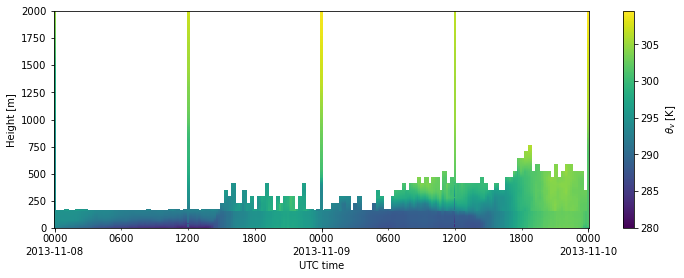

In [34]:
fig,ax,cb = plot_timeheight(combined1,fields='thetav')
#fig,ax,cb = plot_timeheight(combined1,fields='thetav',alpha=0.5,edgecolors='none')

# combined_orig_levels = np.concatenate([tower.index.levels[1],rass.index.levels[1]])
# fig,ax,cb = plot_timeheight(combined1.reindex(index=combined_levels,level=1),
#                             heightlimits=(0,2000),
#                             fields='thetav',alpha=0.5,edgecolors='none')

In [175]:
# estimate radiosonde time window
rise_rate = 300./60 # == 300 m/min
rise_tdelta = pd.to_timedelta(2000. / rise_rate, unit='s')
def repeat_sounding(snd):
    snd0 = snd.drop_duplicates()
    snd1 = snd0.copy()
    assert len(snd1.index.levels[0]) == 1
    dt0 = snd1.index.levels[0][0]
    print(dt0)
    newidx = [dt0 + rise_tdelta]
    snd1 = snd1.drop_duplicates().unstack()
    snd1.index = newidx
    snd1 = snd1.stack()
    newsnd = pd.concat([snd0,snd1]).sort_index() + thetav_offsets.loc[dt0]
    return newsnd

# no shift:
# 2013-11-08 00:00:00
# [293.9] [319.]
# 2013-11-08 00:00:00
# [299.1] [317.5]
# 2013-11-08 12:00:00
# [288.1] [319.9]
# 2013-11-08 12:00:00
# [287.4] [317.9]
# 2013-11-09 00:00:00
# [290.9] [320.6]
# 2013-11-09 12:00:00
# [284.8] [320.7]
# 2013-11-09 12:00:00
# [285.8] [319.1]
# 2013-11-10 00:00:00
# [305.6] [318.8]
# 2013-11-10 00:00:00
# [298.5] [317.9]

2013-11-08 00:00:00
[292.34191467] [317.44191467]
2013-11-08 00:00:00
[297.54191467] [315.94191467]
2013-11-08 12:00:00
[288.76380755] [320.56380755]
2013-11-08 12:00:00
[288.06380755] [318.56380755]
2013-11-09 00:00:00
[293.62673979] [323.32673979]
2013-11-09 12:00:00
[281.87022239] [317.77022239]
2013-11-09 12:00:00
[282.87022239] [316.17022239]
2013-11-10 00:00:00
[304.62748612] [317.82748612]
2013-11-10 00:00:00
[297.52748612] [316.92748612]


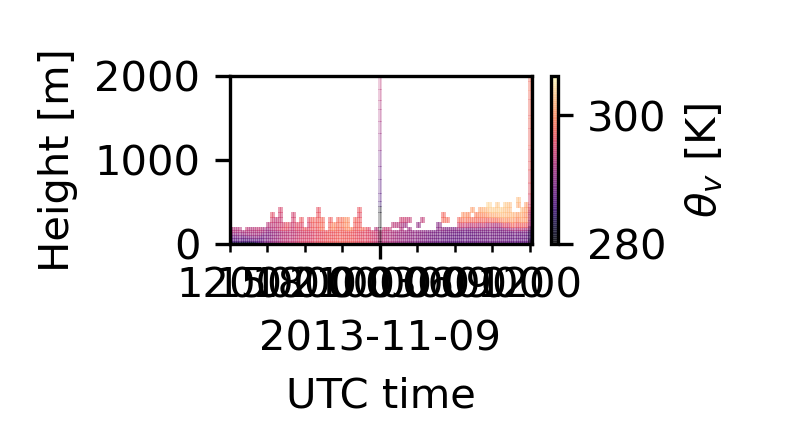

In [180]:
fig,ax = plt.subplots(figsize=(8,3),dpi=300)
starttime,endtime = pd.to_datetime('2013-11-08 12:00'), pd.to_datetime('2013-11-09 12:06')+rise_tdelta
_,_,cb = plot_timeheight(combined,
                         fields='thetav',colorschemes={'thetav':'magma'},
                         timelimits=(starttime,endtime),
                         heightlimits=(0,2000),
                         alpha=0.5,edgecolors='none',
                         fig=fig,ax=ax)

for snd in soundings_raw:
    snd = repeat_sounding(snd)  # workaround for finterp() in _get_staggered_grid()
    print(snd.min().values,snd.max().values)
    _,_,_ = plot_timeheight(snd,
                         fields='thetav',colorschemes={'thetav':'magma'},
                         timelimits=(starttime,endtime),
                         heightlimits=(0,2000),
                         alpha=0.25,edgecolors='none',
                         fig=fig,ax=ax,showcolorbars=False)
fig.savefig('pat+obs/obs_thetav.png',bbox_inches='tight')
fig.savefig('pat+obs/obs_thetav.pdf',bbox_inches='tight')

## basic infill

In [ ]:
# interpolate over time
combined2 = combined1.unstack().interpolate(method='index').stack()

In [ ]:
fig,ax,cb = plot_timeheight(combined2,fields='thetav')
fig.savefig('figures/combined_radar_met_sounding_thetav--linear.png',bbox_inches='tight')

## natural neighbor
this code is a bit messy, based on `process_TTU_radar.ipynb`

In [ ]:
import naturalneighbor

In [ ]:
# output grid _point_ definition (min, max, ds)
# griddata will interpolate to cell _centers_
tdef = [-0.5, len(combined1.index.levels[0])-0.5, 1] # [10 min]
zdef = [0, sowfa_zmax, sowfa_dz] # [m]
griddef = [tdef, zdef, [-0.5,0.5,1]]
griddef

In [ ]:
# check grid definition
tindex  = np.arange(griddef[0][0], griddef[0][1]+0.001, 1)
zpoints = np.arange(griddef[1][0], griddef[1][1]+0.001, sowfa_dz)
na = np.arange(griddef[2][0], griddef[2][1]+0.001, 1)
assert(len(tindex) == len(combined1.index.levels[0])+1)
assert(len(na) == 2)

In [ ]:
# setup output grid
times = combined1.index.levels[0]
tgrid, zgrid = np.meshgrid(times, zpoints, indexing='ij')

In [ ]:
# setup "3D" list of interpolation points
toffset = pd.to_timedelta('10min')
xi = (combined1.index.get_level_values('datetime') - alltimes[0]) / alltimes.freq.delta
yi = combined1.index.get_level_values('height')
zi = np.zeros(len(xi))

In [ ]:
%%time
# perform the interpolation, now that we have all the inputs that griddata expects
points = np.stack((xi,yi,zi),axis=-1)
thetav_NN = naturalneighbor.griddata(points, 
                                     combined1['thetav'],
                                     griddef)

# CPU times: user 19.2 s, sys: 82 ms, total: 19.3 s
# Wall time: 2.95 s

In [ ]:
# use combined2 b/c the unstack--stack operation conveniently regularizes the datetime--heights; those values are overwritten
combined3 = combined2.loc[(slice(None),sowfa_cc_heights),:].copy()
combined3['thetav'] = thetav_NN.squeeze().ravel()

In [ ]:
fig,ax,cb = plot_timeheight(combined3,fields='thetav')
fig.savefig('figures/combined_radar_met_sounding_thetav--NN.png',bbox_inches='tight')

In [ ]:
combined3.to_csv('data/combined_radar_met_sounding_NN.csv')